library import 

In [20]:
import os
import shutil
import random
from pathlib import Path

Data prepare

In [21]:
source_dir = 'E:\\NYU\\pencreatic cancer AI\\activeTest\\sourceData'
output_dir = 'E:\\NYU\\pencreatic cancer AI\\activeTest\\modelUseData'
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# prepare folders
for split in ['train', 'val', 'test']:
    for label in ['Images 0', 'Images 1']:
        Path(f"{output_dir}/{split}/{label}").mkdir(parents=True, exist_ok=True)


for label in ['Images 0', 'Images 1']:
    files = os.listdir(os.path.join(source_dir, label))
    shuffled_files = random.sample(files, len(files))
    
    total = len(shuffled_files)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    split_files = {
        'train': shuffled_files[:train_end],
        'val': shuffled_files[train_end:val_end],
        'test': shuffled_files[val_end:]
    }

    # copy file
    for split, file_list in split_files.items():
        for file in file_list:
            src = os.path.join(source_dir, label, file)
            dst = os.path.join(output_dir, split, label, file)
            shutil.copy(src, dst)

print("Data splitting completed!")

Data splitting completed!


For Training Part

In [22]:
import cv2
import numpy as np

In [23]:
# make each pixel black or white
# parameter: image
# return type: tuple(processed binary image and grayscale original image)

def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    _, binary = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY)  
    return binary, img

In [24]:
# extract features of points include numbers, average brightness, average area and average circularity
# parameter: binary image and gray scale image
# return type: a list of numbers, brightness, area and circularity

def extract_features(binary_img, gray_img):
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    num_objects = len(contours)
    avg_brightness = np.mean(gray_img[gray_img > 30]) if np.any(gray_img > 30) else 0 # Exclude the background
    avg_area = np.mean([cv2.contourArea(c) for c in contours]) if contours else 0
    avg_circularity = np.mean([
        (4 * np.pi * cv2.contourArea(c)) / (cv2.arcLength(c, True)**2 + 1e-6)
        for c in contours if cv2.arcLength(c, True) > 0
    ]) if contours else 0

    return [num_objects, avg_brightness, avg_area, avg_circularity]

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [26]:
# manage photo each here
def load_dataset_from_folder(folder_0, folder_1):
    X, y = [], []
    for label, folder in enumerate([folder_0, folder_1]):
        for fname in os.listdir(folder):
            fpath = os.path.join(folder, fname)
            binary, gray = preprocess_image(fpath)
            features = extract_features(binary, gray)
            X.append(features)
            y.append(label)
    return X, y

In [27]:
# my path
train_0 = os.path.join(output_dir, "train", "Images 0")
train_1 = os.path.join(output_dir, "train", "Images 1")
val_0 = os.path.join(output_dir, "val", "Images 0")
val_1 = os.path.join(output_dir, "val", "Images 1")
test_0 = os.path.join(output_dir, "test", "Images 0")
test_1 = os.path.join(output_dir, "test", "Images 1")

X_train, y_train = load_dataset_from_folder(train_0, train_1)
X_val, y_val = load_dataset_from_folder(val_0, val_1)
X_test, y_test = load_dataset_from_folder(test_0, test_1)

# training model
clf = RandomForestClassifier(n_estimators=50)
clf.fit(X_train, y_train)


# evaluation
print("validate set precision:", accuracy_score(y_val, clf.predict(X_val)))
print("test set precision:", accuracy_score(y_test, clf.predict(X_test)))

validate set precision: 1.0
test set precision: 1.0


Evaluation and Review

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

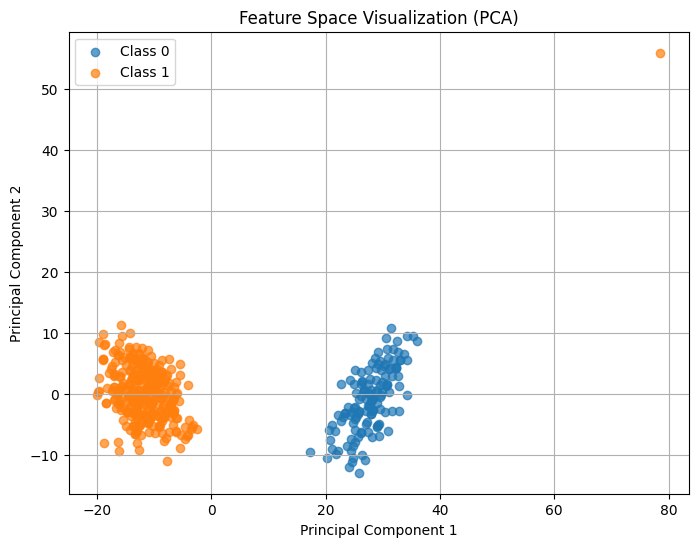

In [ ]:

X_array = np.array(X_train)
y_array = np.array(y_train)


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_array)


plt.figure(figsize=(8,6))
for label in np.unique(y_array):
    idx = y_array == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f'Class {label}', alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Feature Space Visualization (PCA)')
plt.legend()
plt.grid(True)
plt.show()

model internal evaluation

In [30]:
final_model = clf

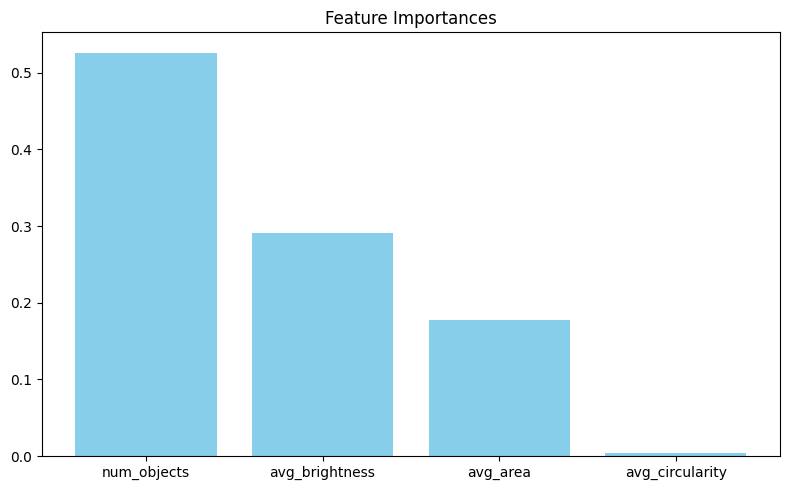

In [31]:
features = ['num_objects', 'avg_brightness', 'avg_area', 'avg_circularity']
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], color="skyblue", align="center")
plt.xticks(range(len(importances)), [features[i] for i in indices])
plt.tight_layout()
plt.show()

In [32]:
from sklearn.tree import export_text


tree_text = export_text(final_model.estimators_[0], feature_names=features)
print(tree_text)

|--- avg_area <= 2.84
|   |--- class: 0.0
|--- avg_area >  2.84
|   |--- avg_brightness <= 82.72
|   |   |--- class: 0.0
|   |--- avg_brightness >  82.72
|   |   |--- class: 1.0

